# **Visualisation of trained model**

In [0]:
pip install git+https://github.com/raghakot/keras-vis.git


Run the above command before running this script.This will install necessary tools needed for visualisation.

In [0]:
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import numpy as np

from vis.utils import utils
from keras import activations

from matplotlib import pyplot
import matplotlib.cm as cm
from scipy.misc import imresize
from vis.visualization import visualize_saliency, overlay,visualize_activation
from vis.visualization import visualize_cam,get_num_filters



Using TensorFlow backend.


Load the trained model for visualisation.

In [0]:
model = keras.models.load_model('alex-net-cv-model_asgmnt_7')


W0713 10:40:59.928735 140328818059136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 10:40:59.950803 140328818059136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 10:40:59.968916 140328818059136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0713 10:41:00.063710 140328818059136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 10:41:00.065082 140328818059136 deprecation_wrap

Below code snippet will display the names of all the layers from the loaded model.

In [0]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  
  print(i, layer.name, layer.output.shape)

0 conv2d_6 (?, 73, 73, 96)
1 max_pooling2d_4 (?, 36, 36, 96)
2 conv2d_7 (?, 26, 26, 256)
3 max_pooling2d_5 (?, 13, 13, 256)
4 conv2d_8 (?, 11, 11, 384)
5 conv2d_9 (?, 9, 9, 384)
6 conv2d_10 (?, 7, 7, 256)
7 max_pooling2d_6 (?, 3, 3, 256)
8 flatten_2 (?, ?)
9 dense_4 (?, 4096)
10 activation_3 (?, 4096)
11 dropout_4 (?, 4096)
12 dropout_5 (?, 4096)
13 dense_5 (?, 1024)
14 activation_4 (?, 1024)
15 dropout_6 (?, 1024)
16 dense_6 (?, 4)


By setting the final dense layer, we can visualise the input that contriibute most towrds the activating the corresponding output nodes.

In [0]:
layer_idx = utils.find_layer_idx(model, 'dense_6')

To visualise the activation of the final dense layer we should switch softmax or sigmoid to linear.

In [0]:
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


The below code snippet will display images from test dataset.Here I'm taking only two class because of computational resource problem.

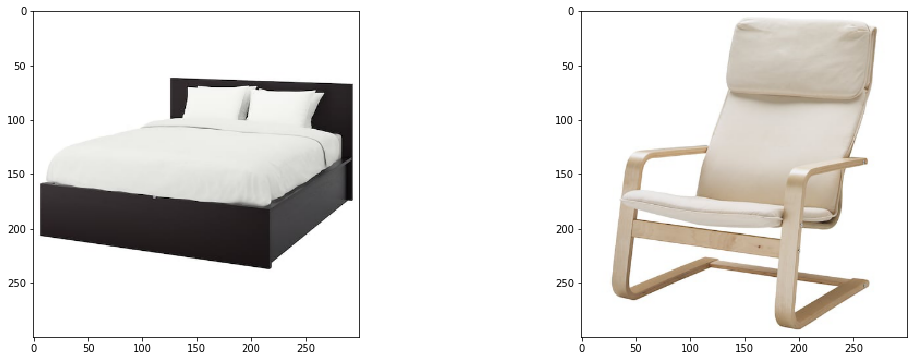

In [0]:
class_idx= 1
pyplot.rcParams['figure.figsize'] = (18, 6)
img1 = utils.load_img('drive/My Drive/assignment/dataset/test/beds/img_5.jpg', target_size=(300,300))
img2=utils.load_img('drive/My Drive/assignment/dataset/test/chairs/img_3.jpg', target_size=(300,300))
f, ax = pyplot.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

# **Saliency Map**

>Saliency is a the quality of being particularly noticeable.The purpose of the saliency map is to represent the conspicuity— or ‘saliency’—at every location in the visual field by a scalar quantity and to guide the selection of attended locations, based on the spatial distribution of saliency. A combination of the feature maps provides bottom-up input to the saliency map, modelled as a dynamical neural network. 





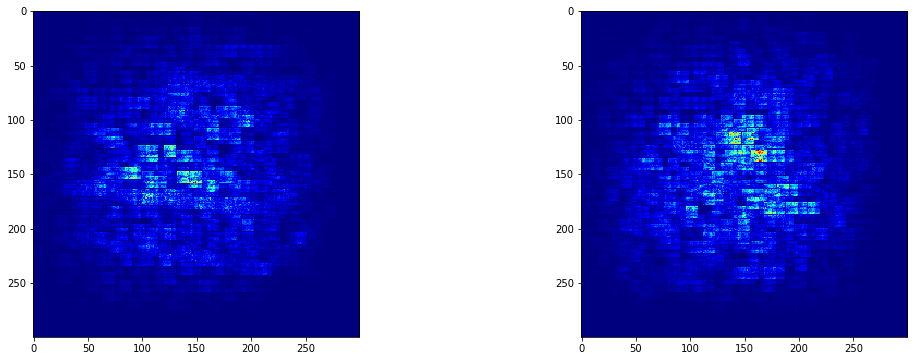

In [0]:
layer_idx_sal = utils.find_layer_idx(model, 'conv2d_10')
f, ax = pyplot.subplots(1, 2)
for i, img in enumerate([img1,img2]):    
    
    grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

<Figure size 1296x432 with 0 Axes>

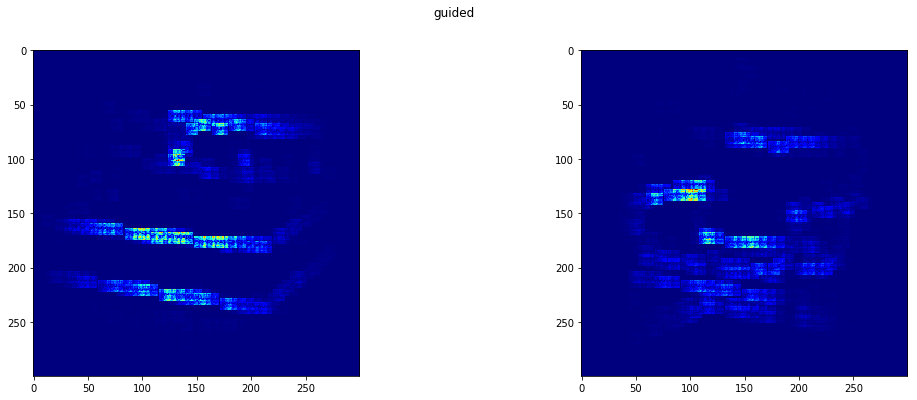

<Figure size 1296x432 with 0 Axes>

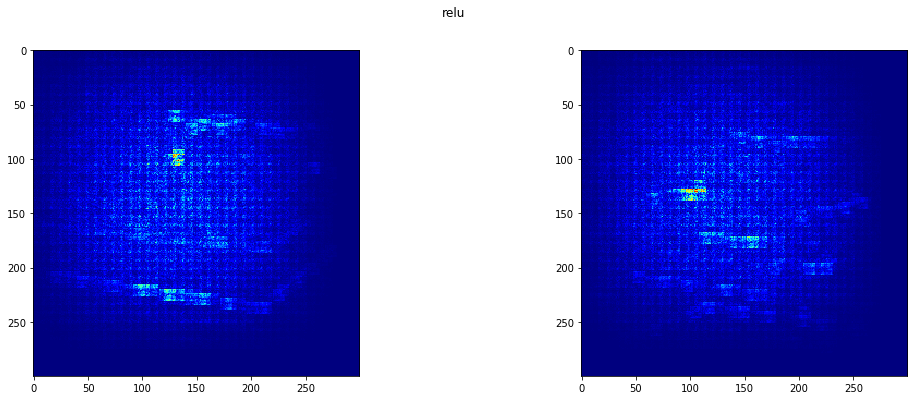

In [0]:
for modifier in ['guided', 'relu']:
    pyplot.figure()
    f, ax = pyplot.subplots(1, 2)
    pyplot.suptitle(modifier)
    for i, img in enumerate([img1,img2]):    
   
        grads = visualize_saliency(model, layer_idx, filter_indices=0, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')


# Attention Maps


> Convolutional Neural Networks have made a lot of progress in Computer Vision. Their accuracy is as good as humans in some tasks. However, it remains difficult to explain the predictions of convolutional neural networks, as they lack the interpretability offered by other models such as decision trees.Attention maps will shows which features are given attention by the network.So this will help us to do retrain the network to focus on important features of the data.



<Figure size 1296x432 with 0 Axes>

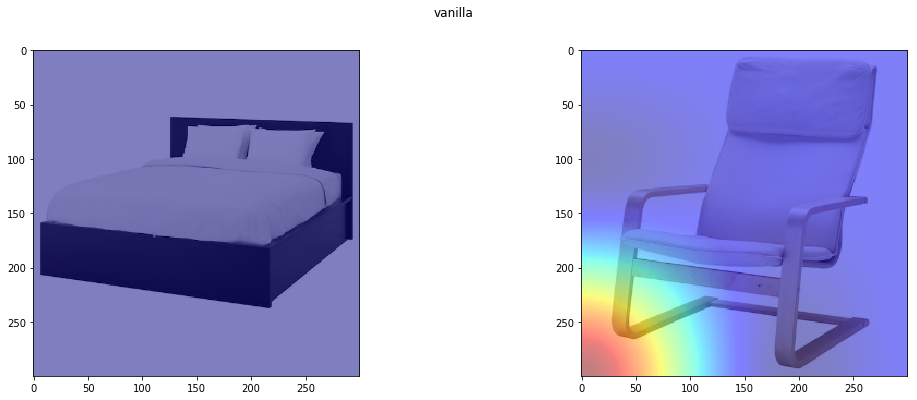

<Figure size 1296x432 with 0 Axes>

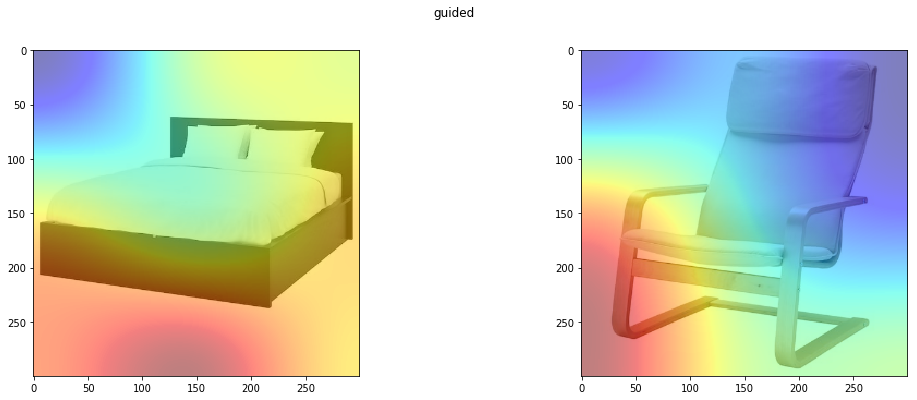

<Figure size 1296x432 with 0 Axes>

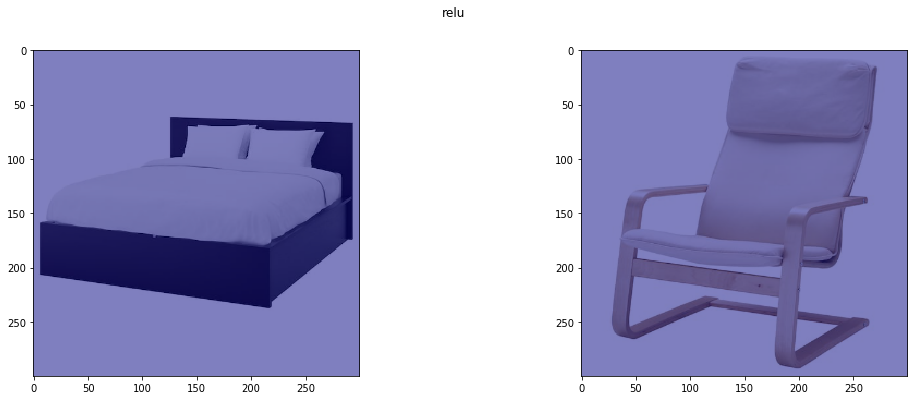

In [0]:
#attention map
for modifier in [None, 'guided', 'relu']:
    pyplot.figure()
    f, ax = pyplot.subplots(1, 2)
    pyplot.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1,img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=1, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))
